In [4]:
# Getting pdbqt files from csv in a list
import os
import shutil
import pandas as pd

# PARAMETERS (edit as needed)
csv_file = 'summaries/top10ListAll.csv'
source_folder = '/home/nikka/VinaScreen/output_sCLUaG1'
destination_folder = 'top10_Ligs/'
filename_column = 'sCLU_Ligand G1'   # <-- set this to the column in your csv with the filenames

# Load CSV and validate column
df = pd.read_csv(csv_file)
if filename_column not in df.columns:
    raise ValueError(f"Column '{filename_column}' not in CSV. Available: {df.columns.tolist()}")

file_list = df[filename_column].dropna().astype(str).tolist()

# Get all files in source directory and create a map: basename (w/o ext) -> real filename
source_files = os.listdir(source_folder)
basename_map = {}
for fname in source_files:
    base, ext = os.path.splitext(fname)
    if base not in basename_map:  # Picks first occurrence if multiple
        basename_map[base] = fname

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Copy files matching base names only
for base_filename in file_list:
    if base_filename in basename_map:
        src_path = os.path.join(source_folder, basename_map[base_filename])
        dest_path = os.path.join(destination_folder, basename_map[base_filename])
        shutil.copy2(src_path, dest_path)
        print(f"Copied: {basename_map[base_filename]}")
    else:
        print(f"No file with base name '{base_filename}' found in source folder.")



Copied: sclum_lig_0060.pdbqt
Copied: sclum_lig_0049.pdbqt
Copied: sclum_lig_0030.pdbqt
Copied: sclum_lig_0081.pdbqt
Copied: sclum_lig_0073.pdbqt
Copied: sclum_lig_0028.pdbqt
Copied: sclum_lig_0053.pdbqt
Copied: sclum_lig_0048.pdbqt
Copied: sclum_lig_0059.pdbqt
Copied: sclum_lig_0069.pdbqt
Copied: sclum_lig_0027.pdbqt


## Visualize structures (2D)


In [13]:
# convert all to single sdf
import os
import glob
import re
from openbabel import pybel
from rdkit import Chem
from rdkit.Chem import SDWriter

source_folder = 'pooled_best'
output_sdf = 'pooled_best.sdf'

def extract_vina_score(pdbqt_file):
    """Extract Vina score from a PDBQT file's REMARK or ROOT line."""
    score = None
    with open(pdbqt_file) as f:
        for line in f:
            # Try REMARK VINA RESULT line (most common)
            if line.startswith("REMARK VINA RESULT:"):
                score_match = re.search(r'REMARK VINA RESULT:\s+([-.\d]+)', line)
                if score_match:
                    score = float(score_match.group(1))
                    break
            # Try classic REMARK line
            elif line.startswith("REMARK"):
                values = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if values:
                    score = float(values[-1])
                    break
    return score

writer = SDWriter(output_sdf)
pdbqt_files = glob.glob(os.path.join(source_folder, "*.pdbqt"))
for pdbqt_file in pdbqt_files:
    basename = os.path.splitext(os.path.basename(pdbqt_file))[0]
    score = extract_vina_score(pdbqt_file)
    
    # Convert to mol object via pybel
    mols = list(pybel.readfile("pdbqt", pdbqt_file))
    if mols:
        mol = mols[0]
        mol.title = basename
        # Convert to RDKit molecule for SDF writing
        mol_block = mol.write("sdf")
        rd_mol = Chem.MolFromMolBlock(mol_block, sanitize=False)
        if rd_mol:
            # Annotate molecule: set vina score and ID
            rd_mol.SetProp("_Name", basename)
            if score is not None:
                rd_mol.SetProp("Vina_Score", str(score))
            writer.write(rd_mol)
writer.close()
print(f"Done. Written all PDBQT structures with scores to {output_sdf}")


Done. Written all PDBQT structures with scores to pooled_best.sdf


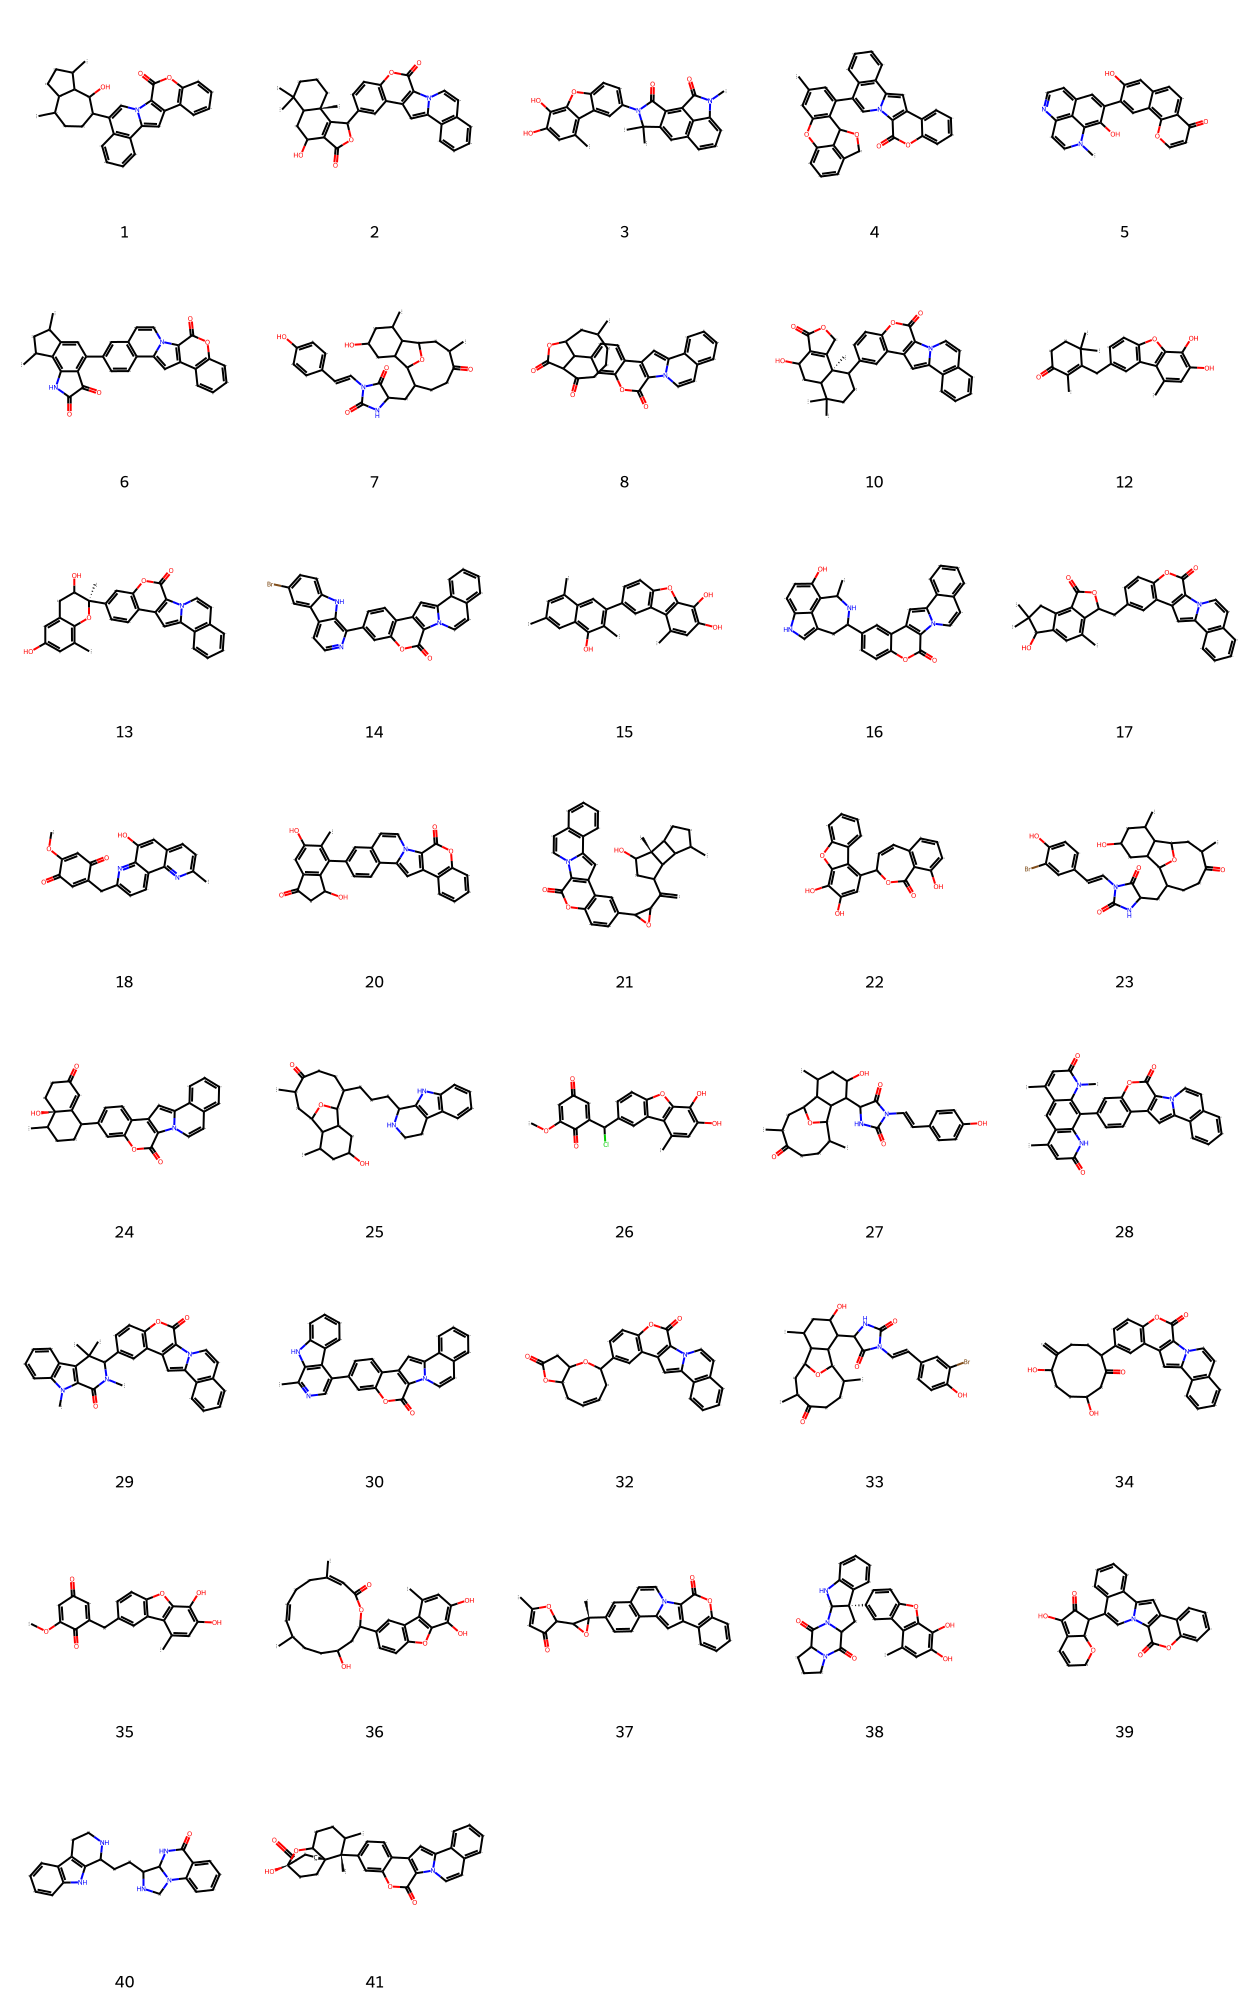

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import math
from IPython.display import display

# Inputs: set as needed
csv_file = 'bestLigs_ADME.csv'
smiles_column = 'SMILES_1'
label_column = 'pool_ID'

mols_per_row = 5  # Adjust for grid layout

df = pd.read_csv(csv_file)
mols = [Chem.MolFromSmiles(sm) for sm in df[smiles_column]]
legends = [str(lbl) for lbl in df[label_column]]

img = Draw.MolsToGridImage(
    mols,
    legends=legends,
    molsPerRow=mols_per_row,
    subImgSize=(250,250),
    useSVG=True
)
display(img)



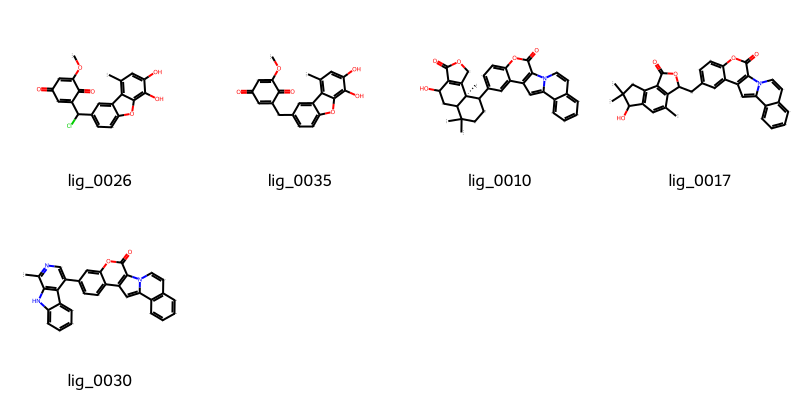

In [14]:
# Visualize 2D structures from sdf
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from IPython.display import display

# Path to your input SDF file
sdf_file = "pooled_best.sdf"

# Read molecules
mols = [mol for mol in Chem.SDMolSupplier(sdf_file) if mol is not None]

# Standardize molecule orientation for visualization
for mol in mols:
    rdDepictor.Compute2DCoords(mol, canonOrient=True)

# Gather IDs for legends (from _Name property or fallback)
labels = [mol.GetProp("_Name") if mol.HasProp("_Name") else f"Mol_{i+1}" for i, mol in enumerate(mols)]

# Draw and display the molecules with IDs below
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200), legends=labels)
display(img)



/tmp/ipykernel_11516/4142882771.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


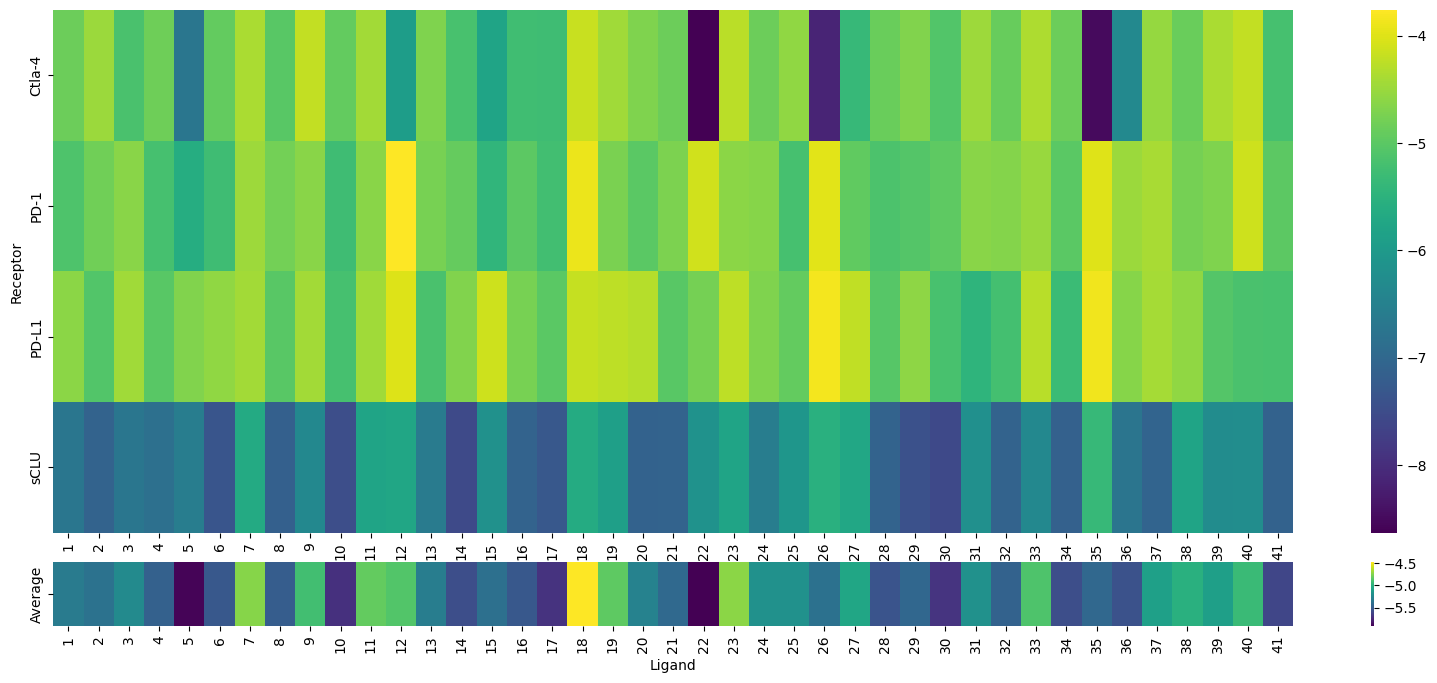

In [10]:
# heatmap of the scores with absolute average
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your CSV data (replace the filename accordingly)
df = pd.read_csv('summaries/pooled_best.csv', index_col=0)

# Compute ligand averages, shape to match heatmap (1 x number of ligands)
ligand_avg = df.mean(axis=0)
avg_matrix = ligand_avg.values[np.newaxis, :]

# Shared colormap, but separate color scales
cmap = sns.color_palette("viridis", as_cmap=True)
vmin_main, vmax_main = df.values.min(), df.values.max()
vmin_avg, vmax_avg = avg_matrix.min(), avg_matrix.max()

fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[9, 1.1], hspace=0.10)

# Main heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    df, ax=ax1, cmap=cmap, vmin=vmin_main, vmax=vmax_main, 
    cbar=True, xticklabels=True, yticklabels=True
)
ax1.set_ylabel('Receptor')
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Ligand averages, independent color scale
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
sns.heatmap(
    avg_matrix, ax=ax2, cmap=cmap, vmin=vmin_avg, vmax=vmax_avg, 
    #cbar=True, cbar_ax=fig.add_axes([0.92, 0.12, 0.015, 0.25]),  # independent vertical colorbar
    xticklabels=df.columns, yticklabels=['Average']
)
ax2.set_ylabel('')
ax2.set_xlabel('Ligand')
ax2.set_yticks([0.5])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.tight_layout(rect=[0, 0, 0.91, 1])
plt.show()


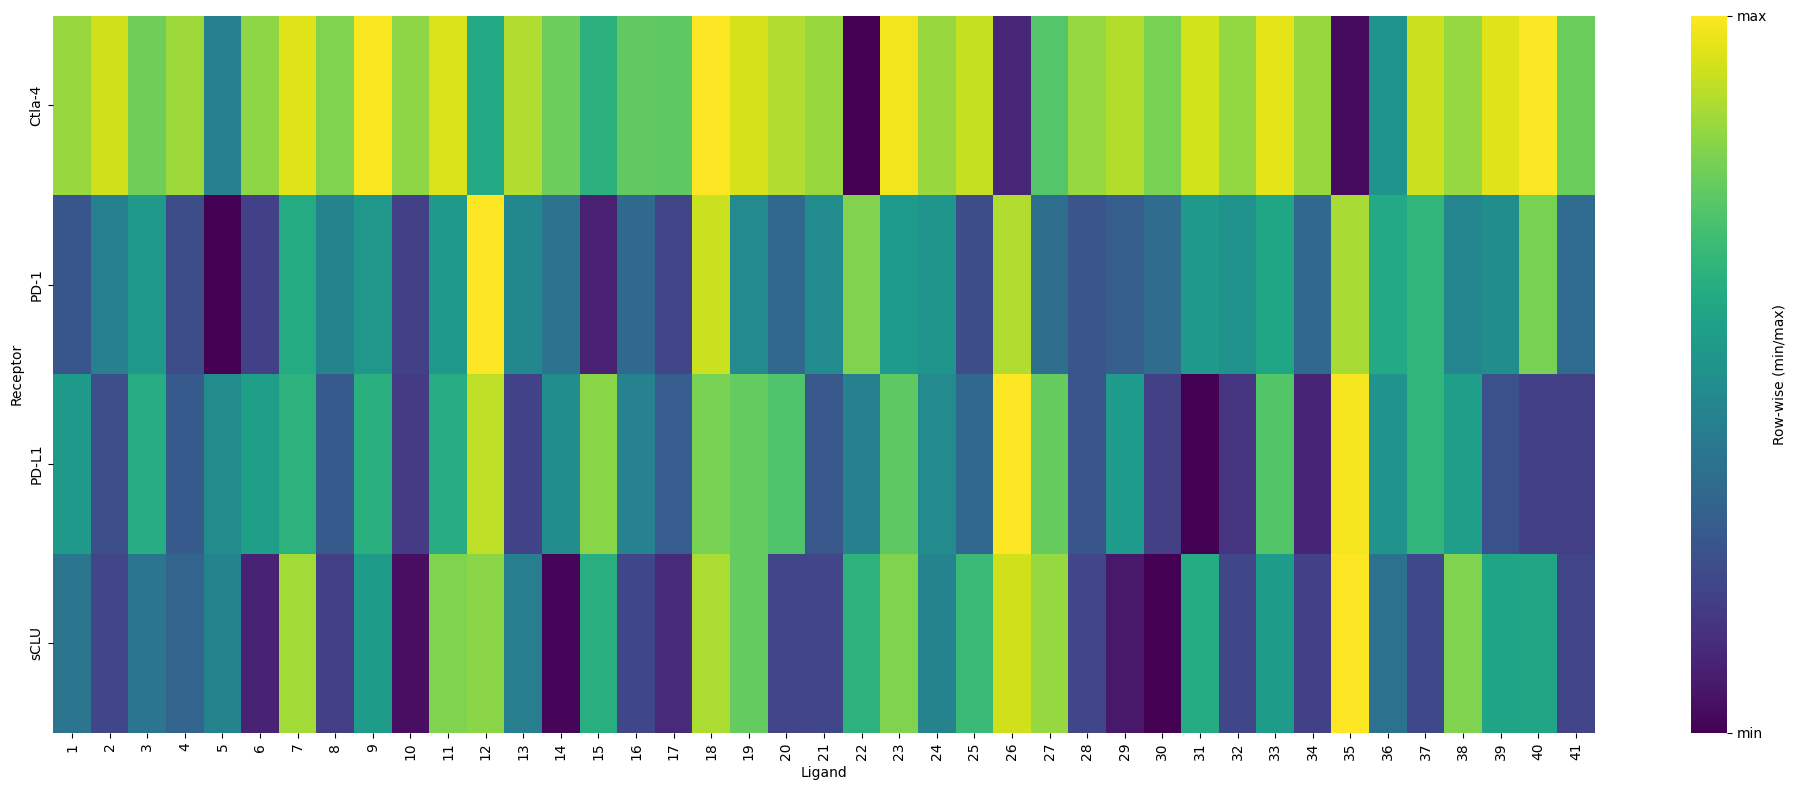

In [8]:
# normalized across rows heatmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Load your data
df = pd.read_csv('summaries/pooled_best.csv', index_col=0)

# Row-wise normalization (scale each row to 0-1)
df_normalized = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Create the heatmap
fig, ax = plt.subplots(figsize=(20, 8))
cmap = sns.color_palette("viridis", as_cmap=True)

sns.heatmap(df_normalized, ax=ax, cmap=cmap, cbar=True, xticklabels=True, yticklabels=True)

# Custom colorbar (legend): only "min" and "max"
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['min', 'max'])
colorbar.set_label('Row-wise (min/max)')

# Labels
ax.set_ylabel('Receptor')
ax.set_xlabel('Ligand')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


/tmp/ipykernel_11516/1368783544.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


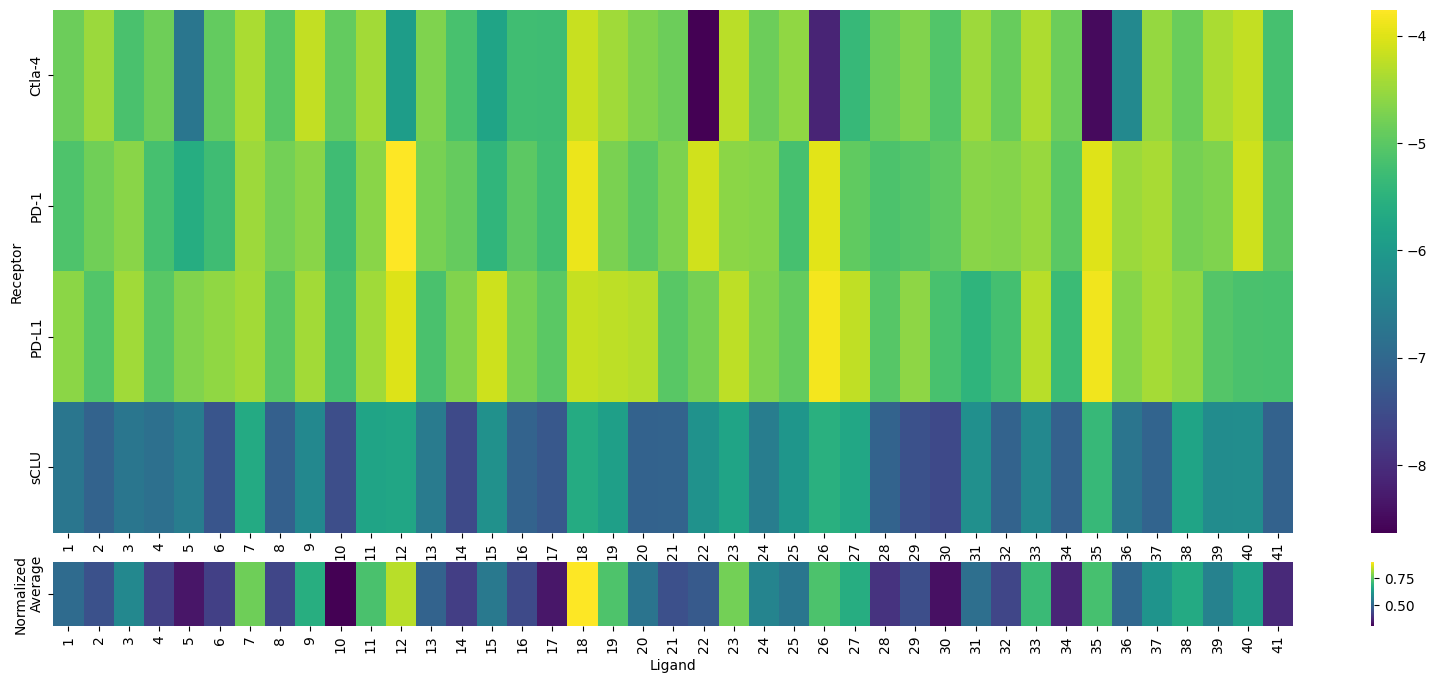

In [12]:
# normalized average across each receptor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load your CSV data
df = pd.read_csv('summaries/pooled_best.csv', index_col=0)

# Normalize each row to [0, 1]
df_norm = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Calculate average of normalized scores for each ligand (column)
ligand_norm_avg = df_norm.mean(axis=0)
norm_avg_matrix = ligand_norm_avg.values[np.newaxis, :]  # Shape (1, number of ligands)

cmap = sns.color_palette("viridis", as_cmap=True)
vmin_main, vmax_main = df.values.min(), df.values.max()
vmin_avg, vmax_avg = norm_avg_matrix.min(), norm_avg_matrix.max()

fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[9, 1.1], hspace=0.10)

# Main (absolute) heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    df, ax=ax1, cmap=cmap, vmin=vmin_main, vmax=vmax_main,
    cbar=True, xticklabels=True, yticklabels=True
)
ax1.set_ylabel('Receptor')
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Heatmap for normalized ligand averages (independent min/max)
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
sns.heatmap(
    norm_avg_matrix, ax=ax2, cmap=cmap, vmin=vmin_avg, vmax=vmax_avg,
    xticklabels=df.columns, yticklabels=['Normalized\nAverage']
)
ax2.set_ylabel('')
ax2.set_xlabel('Ligand')
ax2.set_yticks([0.5])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.tight_layout(rect=[0, 0, 0.91, 1])
plt.show()
